In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os
from tensorflow.keras.layers import Conv2D,Conv1D, GlobalAveragePooling2D, Dense, Dropout, DepthwiseConv2D, DepthwiseConv1D

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [8]:
# Specify the path to your model and the data directories and parameters

MODEL_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/models/2025_07_31_plant_classifier_fine_tuned__model.keras"
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/valid"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

In [10]:
# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_DIR 
,custom_objects={'preprocess_input': preprocess_input})

# Display the model architecture
model.summary()  

# Check input shape compatibility
print(f"Model input shape: {model.input_shape}")
print(f"Number of classes: {num_classes}")  # Should be 38


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

Model input shape: (None, 224, 224, 3)
Number of classes: 38


In [11]:
# Print all layers of the model used (MobileNetV2)
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_15 (InputLayer)
1: sequential_2 (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d_6 (GlobalAveragePooling2D)
4: dropout_6 (Dropout)
5: dense_6 (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75:

In [26]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in validation_dataset.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in validation_dataset.take(2)][0])

# Select specific images
images = X[:4]
labels = y[:4]

2025-08-05 15:54:25.943073: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Get the base MobileNetV2 model (index 2 in your model)
    base_model = model.layers[2]
    
    # Create grad_model using the base model's target layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )
    
    # Expand dimensions but DON'T preprocess (model handles preprocessing)
    img_array_expanded = np.expand_dims(img_array, axis=0).astype(np.float32)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array_expanded)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), pred_index.numpy()

# Use fully qualified layer name
show_grad_cam_and_predictions(images, labels, model, class_names, 'block_13_project')

KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m13515885328\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[ 10.,   6.,  26.],\n         [101.,  93., 118.],\n         [101.,  92., 119.],\n         ...,\n         [167., 166., 197.],\n         [167., 166., 197.],\n         [168., 167., 198.]],\n\n        [[ 10.,   6.,  26.],\n         [102.,  93., 118.],\n         [102.,  93., 120.],\n         ...,\n         [166., 165., 196.],\n         [166., 165., 196.],\n         [167., 166., 197.]],\n\n        [[ 10.,   6.,  26.],\n         [102.,  94., 118.],\n         [103.,  94., 121.],\n         ...,\n         [164., 163., 194.],\n         [164., 163., 194.],\n         [165., 164., 195.]],\n\n        ...,\n\n        [[ 15.,   7.,  19.],\n         [120., 107., 124.],\n         [122., 109., 128.],\n         ...,\n         [185., 185., 213.],\n         [185., 185., 213.],\n         [185., 185., 213.]],\n\n        [[ 17.,   7.,  21.],\n         [121., 108., 125.],\n         [122., 109., 127.],\n         ...,\n         [184., 184., 212.],\n         [184., 184., 212.],\n         [183., 183., 211.]],\n\n        [[ 18.,   7.,  22.],\n         [121., 108., 126.],\n         [121., 108., 127.],\n         ...,\n         [183., 183., 211.],\n         [183., 183., 211.],\n         [182., 182., 210.]]]], dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

<Figure size 1500x2000 with 0 Axes>

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:43<00:10, 10.91s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:05<00:00, 15.43s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:26, 21.52s/it]                       


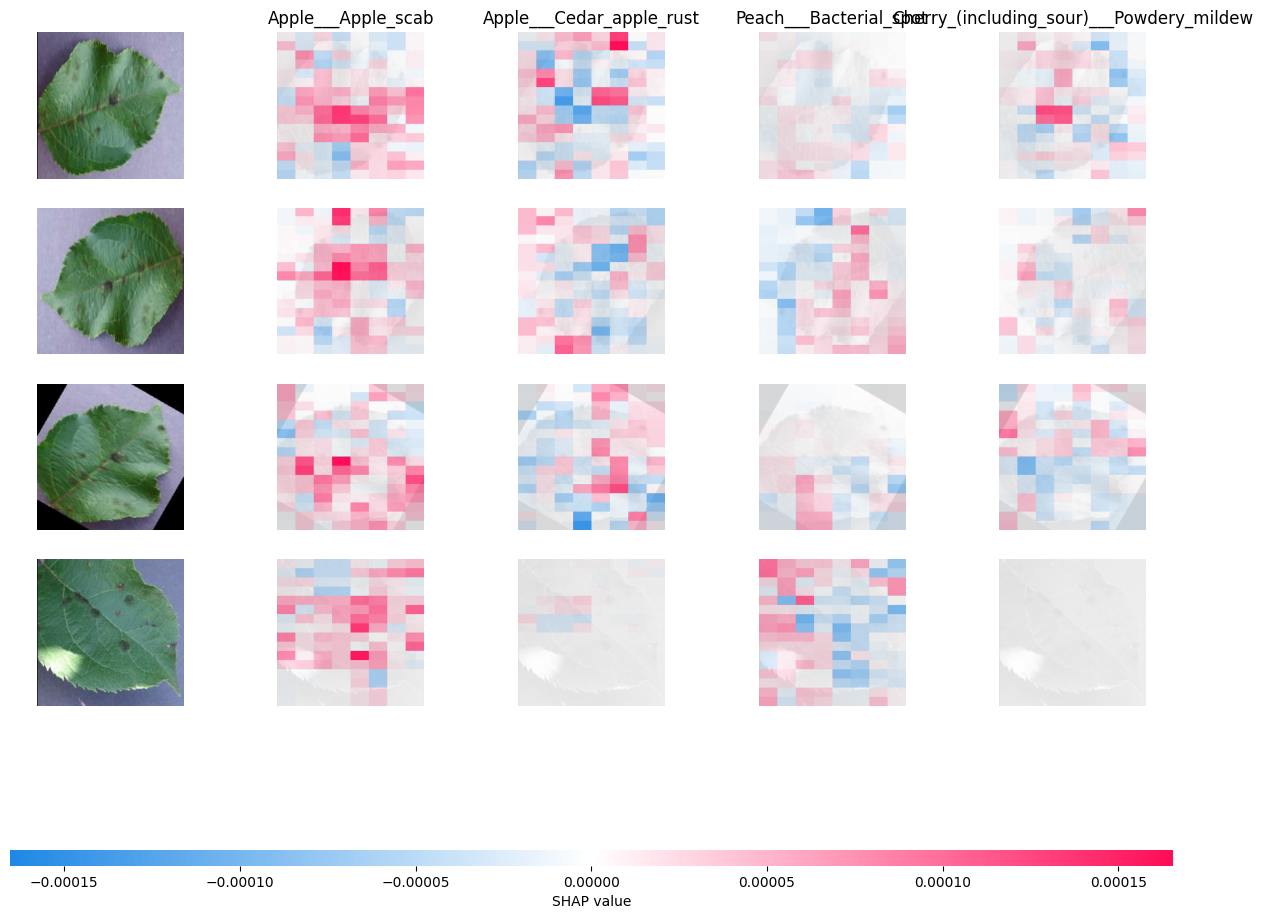

In [185]:
# --- SHAP Explanations ---
masker = shap.maskers.Image("inpaint_telea", images[0].shape) # inpaint_telea blurs the image regions to explain 

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(images, 
                        max_evals=1000,  
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

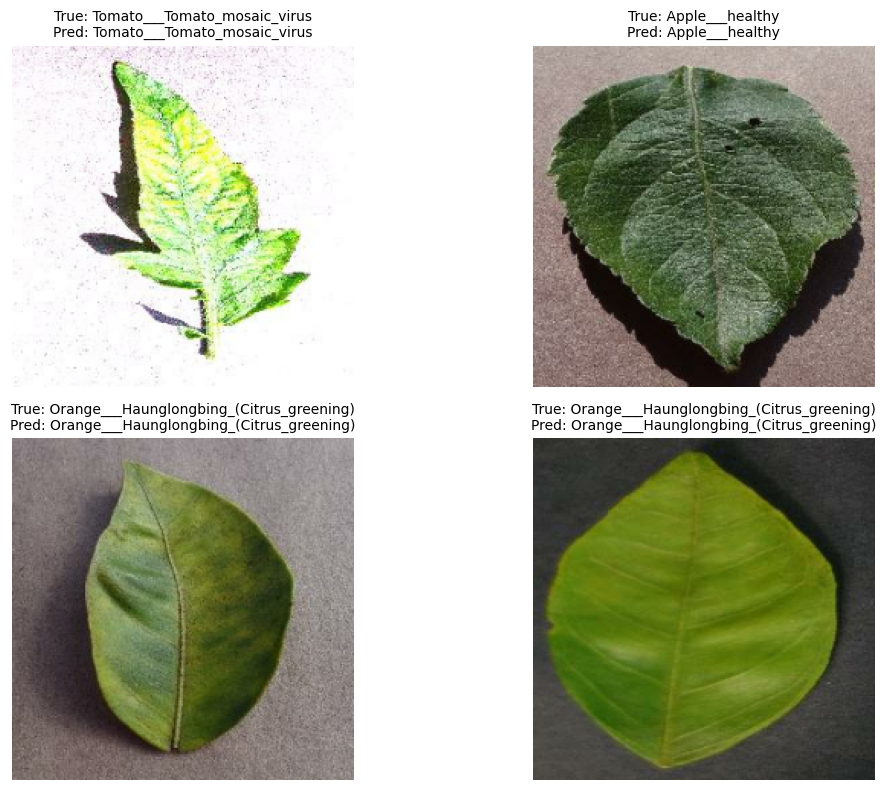

In [ ]:
class_names = train_dataset.class_names  

# Collect all images and labels into arrays
all_images = []
all_labels = []

for images, labels in validation_dataset:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Select 4 random indices
random_indices = random.sample(range(len(all_images)), 4)

# Set up the plot
plt.figure(figsize=(12, 8))

for i, idx in enumerate(random_indices):
    image = all_images[idx]
    true_label = class_names[all_labels[idx]]

    # Make prediction
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_label = class_names[np.argmax(pred)]

    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.astype("uint8"))  # Adjust depending on preprocessing
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()
